In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypfopt.cla import CLA
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2012, 7, 4), datetime.date(2022, 7, 2))

In [3]:
sharpes = pd.read_csv('sharpes.csv')
sharpes.head()

,stock,sharpe
0,ASAN,4.146624
1,efc,3.530101
2,stry,3.398456
3,lly,3.048137
4,eve,2.531150


<a href="https://www.advfn.com/nyse/newyorkstockexchange.asp?companies=U">NYSE listings</a>

In [6]:
KEEP_TOP_N = 50
sym = (
    'tmst twi tost tol tr bld tmk ttc td curv shll snpr ndp tyg ntg ttp '
    'tpz trtl tss towr tsq cook tcoa tt tac tru tai tci tdg alsn rig tgs '
    'tnl treb trec tg ths taca trex ty tnet trco tcn tsl trne traq trn '
    'tse gts tpvy tpvg tris trtn tgi trox tbi tfc tnp tufn tup tpb trq '
    'tpc tuya twlo trca trwh twtr two tyc tyl tsn ubs udr ugi ugic umh usm'
)
missing = (
    'shll tai trco tmk tsl towr trwh snpr trne gts treb tyc tss'
)
SYMBOLS = [s for s in sym.split() if s not in missing.split()]
#SYMBOLS

In [8]:
data = (
    yf.download(SYMBOLS, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
data.columns = SYMBOLS
data.head()

[*********************100%***********************]  65 of 65 completed


,tmst,twi,tost,tol,tr,bld,ttc,td,curv,ndp,...,twtr,two,tyl,tsn,ubs,udr,ugi,ugic,umh,usm
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-05,15.698521,NaN,NaN,NaN,NaN,112.249588,38.577713,12.267245,NaN,16.110001,...,NaN,10.332285,75.380608,41.700001,8.573902,18.671175,15.213560,NaN,6.374621,33.725098
2012-07-06,15.454803,NaN,NaN,NaN,NaN,113.181290,37.749718,12.161430,NaN,16.129999,...,NaN,10.265626,75.550362,40.759998,8.302671,18.721518,15.304632,NaN,6.346589,33.776562
2012-07-09,15.463217,NaN,NaN,NaN,NaN,112.648888,37.352619,12.133214,NaN,15.850000,...,NaN,10.272290,75.097710,40.790001,8.242398,18.815025,15.324868,NaN,6.559636,33.502094
2012-07-10,14.816110,NaN,NaN,NaN,NaN,113.358780,36.583767,12.062675,NaN,15.680000,...,NaN,10.232295,75.456047,40.779999,8.099248,18.563288,15.431115,NaN,6.503571,33.742252
2012-07-11,14.412727,NaN,NaN,NaN,NaN,113.092575,37.192089,12.097944,NaN,15.530000,...,NaN,10.218964,75.437202,40.639999,8.129385,18.512945,15.517122,NaN,6.497966,34.076756


In [9]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [10]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [11]:
new_sharpes = []
for stock in SYMBOLS:
    sharpe = get_sharpe(get_daily_returns(data[stock]))
    new_sharpes.append([stock, sharpe])
    
sharpe_df = (
    pd.DataFrame(new_sharpes, columns=['stock', 'sharpe'])
    .sort_values('sharpe', ascending=False))
sharpe_df.head(15)

,stock,sharpe
1,twi,0.885940
58,tsn,0.883504
46,tnp,0.831684
35,traq,0.823694
14,trtl,0.804412
47,tufn,0.785211
44,tbi,0.749709
32,ty,0.731471
10,tyg,0.725508
42,tgi,0.709273


In [12]:
sharpes = (
    pd.concat([sharpes, sharpe_df])
    .sort_values('sharpe', ignore_index=True, ascending=False)
    .drop_duplicates())
sharpes.head(20)

,stock,sharpe
0,ASAN,4.146624
1,efc,3.530101
2,stry,3.398456
3,lly,3.048137
4,eve,2.531150
5,chmt,2.475858
6,hhs,2.406309
7,bxsl,2.249160
8,APSG,2.178348
9,dwin,1.886962


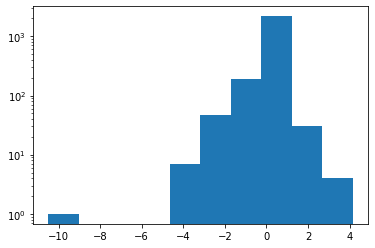

In [13]:
plt.hist(sharpes.sharpe)
plt.yscale('log');

In [14]:
sharpes.loc[sharpes.stock == 'sfg', :]

,stock,sharpe


In [15]:
omit = ('sfg')
inds = []
for o in omit.split():
    inds += (sharpes.loc[sharpes.stock == o, :].index.tolist())

sharpes.drop(index=inds, inplace=True)

In [16]:
sharpes.to_csv('sharpes.csv', index=False)

In [17]:
sharpes.shape

(2474, 2)

In [18]:
MIX = sharpes.stock.unique().tolist()[:400]
len(MIX)
df = yf.download(MIX, start=START, end=TODAY)
df.drop(
    columns=['Open', 'Close', 'Volume', 'High', 'Low'], inplace=True)
print(df.shape)
df.head()

[*********************100%***********************]  400 of 400 completed
(2517, 400)


Adj Close                                                     \
                  ABC      ABEV        ABM ACA      ACRE ADCT        ADM   
Date                                                                       
2012-07-05  33.658722  4.541556  15.832622 NaN  7.280922  NaN  21.682364   
2012-07-06  33.061634  4.461032  15.595951 NaN  7.162397  NaN  21.598675   
2012-07-09  33.181049  4.449320  15.147093 NaN  7.158161  NaN  20.959620   
2012-07-10  33.215168  4.396614  15.024672 NaN  7.268222  NaN  20.974838   
2012-07-11  33.513706  4.390759  14.894093 NaN  7.132762  NaN  21.043304   

                                            ...                       \
                 AEG        AEL        AEO  ...       TWO         TY   
Date                                        ...                        
2012-07-05  2.878119  10.095475  14.583704  ...  5.480256  10.332286   
2012-07-06  2.807293  10.195430  14.470262  ...  5.546901  10.265626   
2012-07-09  2.813732  10.240867  14.526981  ...  5.593038  10.272292   
2012-07-10  2.800854  10.113650  14.470262  ...  5.577660  10.232294   
2012-07-11  2.852364  10.186345  14.115774  ...  5.552027  10.218962   

                                                                             \
                  TYG         UAN       VLT       WLYB WNNR        XOM XPOA   
Date                                                                          
2012-07-05  75.380623  131.354050  7.652506  39.088806  NaN  56.306480  NaN   
2012-07-06  75.550346  132.096176  7.599880  38.775028  NaN  55.799809  NaN   
2012-07-09  75.097717  130.929977  7.656893  38.775028  NaN  55.043087  NaN   
2012-07-10  75.456062  130.876984  7.661276  38.092556  NaN  54.687771  NaN   
2012-07-11  75.437195  128.173584  7.665660  38.092556  NaN  55.523441  NaN   

                
           YOU  
Date            
2012-07-05 NaN  
2012-07-06 NaN  
2012-07-09 NaN  
2012-07-10 NaN  
2012-07-11 NaN  

[5 rows x 400 columns]

In [19]:
df.columns = MIX
MAX_MISSING = 30
n_nan = df.isnull().sum()
n_nan
drop = n_nan[n_nan > MAX_MISSING].index
df = df.drop(columns=drop)
print(df.shape)
df.head()

(2517, 233)


,ASAN,efc,stry,eve,hhs,bxsl,APSG,dwin,pnw,irs,...,edd,oilu,sswa,gty,cas,ra,gs,flag,rba,door
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-05,33.658722,4.541556,15.832622,7.280922,21.682364,2.878119,10.095475,14.583704,15.671316,4.847691,...,2.841863,15.130071,24.844643,5.480256,10.332286,75.380623,131.354050,7.652506,39.088806,56.306480
2012-07-06,33.061634,4.461032,15.595951,7.162397,21.598675,2.807293,10.195430,14.470262,14.973041,4.821486,...,2.869137,14.968389,24.081099,5.546901,10.265626,75.550346,132.096176,7.599880,38.775028,55.799809
2012-07-09,33.181049,4.449320,15.147093,7.158161,20.959620,2.813732,10.240867,14.526981,15.012942,4.882629,...,2.880046,14.542911,24.286663,5.593038,10.272292,75.097717,130.929977,7.656893,38.775028,55.043087
2012-07-10,33.215168,4.396614,15.024672,7.268222,20.974838,2.800854,10.113650,14.470262,14.234862,4.873895,...,2.880046,14.525887,23.963627,5.577660,10.232294,75.456062,130.876984,7.661276,38.092556,54.687771
2012-07-11,33.513706,4.390759,14.894093,7.132762,21.043304,2.852364,10.186345,14.115774,14.264788,4.838956,...,2.847318,14.517381,23.611219,5.552027,10.218962,75.437195,128.173584,7.665660,38.092556,55.523441


In [20]:
import cvxpy
cvxpy.installed_solvers()

['ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']

In [21]:
mu = mean_historical_return(df)
s = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, s, solver='ECOS')# , verbose=True)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
for k, v in dict(cleaned_weights).items():
    if v > 0:
        print(f'{k:6s}: {v}')

AZEK  : 0.00301
sndr  : 0.01514
sah   : 0.0059
gia   : 0.0529
ATA   : 0.05829
sfl   : 0.00589
burl  : 0.02996
cldt  : 0.03561
chn   : 0.00246
csv   : 0.02344
leju  : 0.12817
fif   : 0.01967
ce    : 0.05116
AGD   : 0.0284
bam   : 0.09283
tinv  : 0.18199
rcc   : 0.11538
tslx  : 0.11623
oilu  : 0.03356


In [22]:
_, _, s1 = ef.portfolio_performance(verbose=True)

Expected annual return: 22.5%
Annual volatility: 13.3%
Sharpe Ratio: 1.54


In [23]:
s1

1.5431865916411975

In [24]:
vol = np.linspace(0.10, 0.30, 50)
rets = []
sharpes = []
for v in vol:
    print(f'Vol: {v}   ', end='\r')
    ef = EfficientFrontier(mu, s, solver='ECOS')
    w = ef.efficient_risk(target_volatility=v)
    r, _, sh = ef.portfolio_performance()
    rets.append(r)
    sharpes.append(sh)

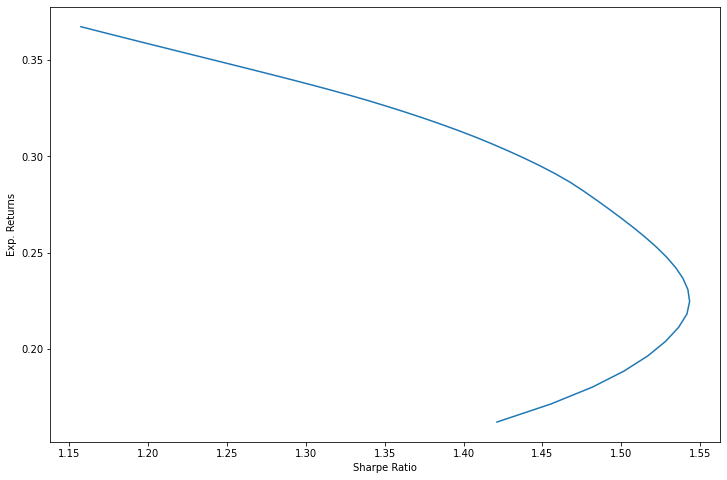

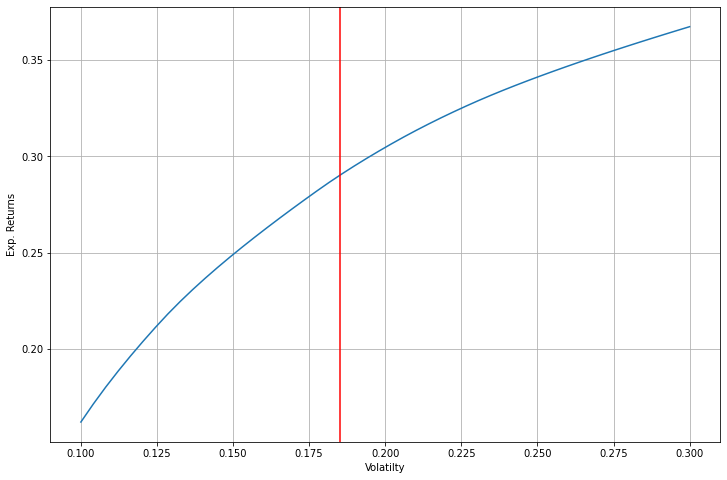

In [25]:
plt.figure(figsize=[12,8])
plt.plot(sharpes, rets)
plt.xlabel('Sharpe Ratio')
plt.ylabel('Exp. Returns');

plt.figure(figsize=[12,8])
plt.plot(vol, rets)
plt.grid(True)
plt.axvline(x=0.185, color='r')
plt.xlabel('Volatilty')
plt.ylabel('Exp. Returns');

In [26]:
OPTIMAL_VOL = 0.185
ef = EfficientFrontier(mu, s, solver='ECOS')
weights = ef.efficient_risk(target_volatility=OPTIMAL_VOL)
cleaned_weights = ef.clean_weights()
for k, v in dict(cleaned_weights).items():
    if v > 0:
        print(f'{k:6s}: {v}')

AZEK  : 0.01049
sndr  : 0.01693
gia   : 0.05968
ATA   : 0.0677
csv   : 0.00412
leju  : 0.19956
fif   : 0.03368
ce    : 0.04169
AGD   : 0.07834
bam   : 0.0531
rcc   : 0.1994
tslx  : 0.22418
oilu  : 0.01114


In [27]:
_, _, s1 = ef.portfolio_performance(verbose=True)

Expected annual return: 29.0%
Annual volatility: 18.5%
Sharpe Ratio: 1.46


In [28]:
s1

1.4600290172720884